In [2]:
import pandas as pd
import numpy as np
import psycopg2 as psy
from psycopg2 import sql
from sqlalchemy import create_engine
import os
import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, precision_score, recall_score, 
                             accuracy_score, plot_roc_curve, auc, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from mimic_fxns import produce_results
#(connect, insert_data, data_extraction, transform_labs, 
#                             hot_coding, age_bands, month_transform, data_processing, 
#                             produce_results)
from icu_mortality_model import build_icu_model, build_x_y

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



In [3]:
train_labs = 'train_lab_values.sql'
train_admits = 'v_two_data_set_extraction.sql'
train_vitals = 'train_chart_events.sql'
train_echoecg = 'train_echo_ecg_notes - model.sql'


In [4]:
X, y = build_x_y(train_labs, train_admits, train_vitals, train_echoecg)
cm_rf = build_icu_model('rf', train_labs, train_admits, train_vitals, train_echoecg, make_pickl=False)

Connecting to PostgreSQL database...
Connection successful
Lab data loaded...
Patient admitting data loaded...
Vitals data loaded...
Echo and ECG data loaded...
Preparing data for model fitting and/or evaluation...
post chronic (31459, 41)
(30133, 18) post labs (31459, 57)
(12202, 5) post echo (31811, 60)
Data preparation complete.
Connecting to PostgreSQL database...
Connection successful
Lab data loaded...
Patient admitting data loaded...
Vitals data loaded...
Echo and ECG data loaded...
Preparing data for model fitting and/or evaluation...
post chronic (31459, 41)
(30133, 18) post labs (31459, 57)
(12202, 5) post echo (31811, 60)
Data preparation complete.
Fitting model...
Model complete.


In [5]:
print('ding dong... all done!')

ding dong... all done!


In [6]:
cm_lr = build_icu_model('lr', train_labs, train_admits, train_vitals, train_echoecg, make_pickl=False)

Connecting to PostgreSQL database...
Connection successful
Lab data loaded...
Patient admitting data loaded...
Vitals data loaded...
Echo and ECG data loaded...
Preparing data for model fitting and/or evaluation...
post chronic (31459, 41)
(30133, 18) post labs (31459, 57)
(12202, 5) post echo (31811, 60)
Data preparation complete.
Fitting model...
Model complete.


In [7]:
ho_labs = 'ho_lab_values.sql'
ho_admits = 'v_two_data_set_extraction_holdout.sql'
ho_vitals = 'ho_chart_events.sql'
ho_echoecg = 'ho_echo_ecg_notes - model.sql'
Xho, yho = build_x_y(ho_labs, ho_admits, ho_vitals, ho_echoecg)

Connecting to PostgreSQL database...
Connection successful
Lab data loaded...
Patient admitting data loaded...
Vitals data loaded...
Echo and ECG data loaded...
Preparing data for model fitting and/or evaluation...
post chronic (20973, 41)
(20397, 18) post labs (20973, 57)
(8063, 5) post echo (21131, 60)
Data preparation complete.


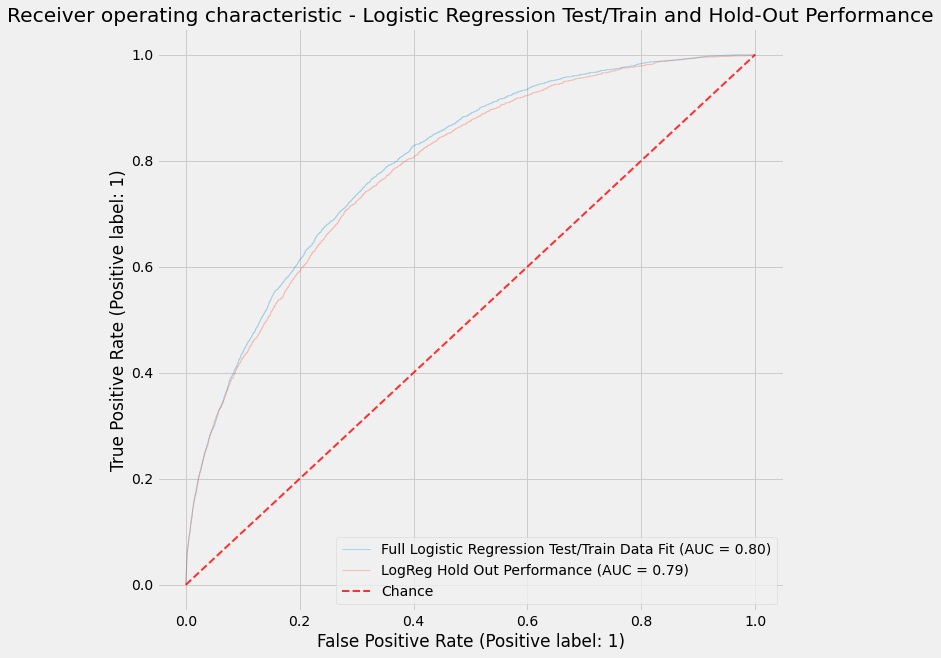

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
viz = plot_roc_curve(cm_lr, X, y, name='Full Logistic Regression Test/Train Data Fit', alpha = .3, lw=1, ax=ax)
vizho = plot_roc_curve(cm_lr, Xho, yho, name='LogReg Hold Out Performance', alpha = .3, lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic - Logistic Regression Test/Train and Hold-Out Performance")
ax.legend(loc="lower right")
plt.show()

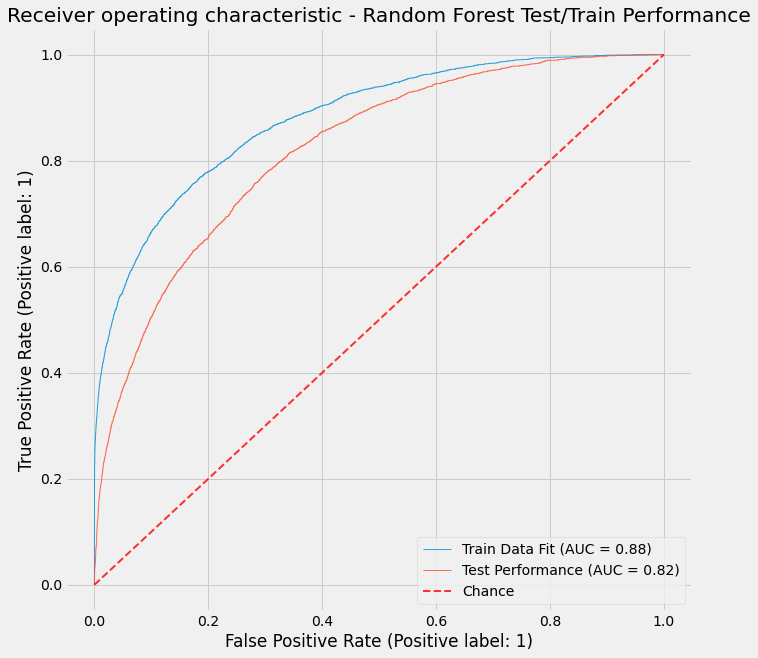

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
viz = plot_roc_curve(cm_rf, X, y, name='Train Data Fit', alpha = .8, lw=1, ax=ax)
vizho = plot_roc_curve(cm_rf, Xho, yho, name='Test Performance', alpha = .8, lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic - Random Forest Test/Train Performance")
ax.legend(loc="lower right")
plt.show()

RandomForestClassifier(max_depth=9, n_estimators=250, n_jobs=-1,
                       random_state=18)
Score is 0.8924271478419414
Precision is 0.9962453066332916 and recall is 0.1888493475682088


(0.8924271478419414, 0.9962453066332916, 0.1888493475682088)

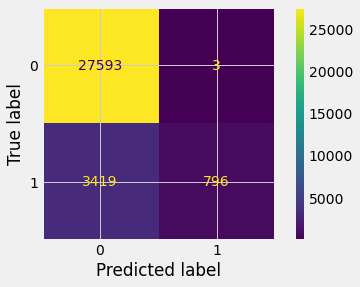

In [10]:
produce_results(cm_rf, X, y, pprint=True)

RandomForestClassifier(max_depth=9, n_estimators=250, n_jobs=-1,
                       random_state=18)
Score is 0.8765794330604325
Precision is 0.7759562841530054 and recall is 0.10106761565836299


(0.8765794330604325, 0.7759562841530054, 0.10106761565836299)

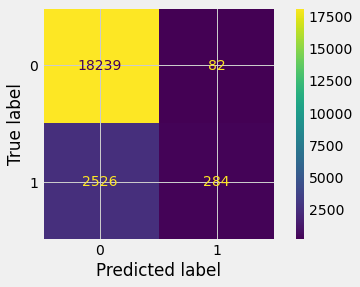

In [11]:
produce_results(cm_rf, Xho, yho, pprint=True)

In [12]:
out = pd.DataFrame(zip(y, cm_rf.predict(X), np.round(cm_rf.predict_proba(X)[:,1],3)), columns = ['y', 'yhat', 'prob'])

In [13]:
out['align'] = out['y'] + out['yhat']
true_pos = out.loc[out['align'] == 2, 'prob']
true_neg = out.loc[out['align'] == 0, 'prob']
err = out.loc[out['align'] == 1, 'prob']

Text(0.5, 1.0, 'True Negative Prob ranges')

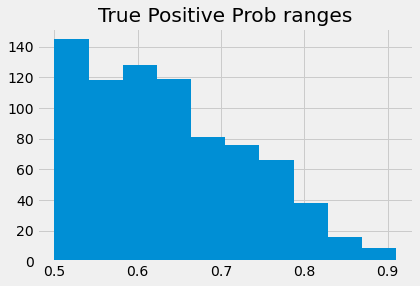

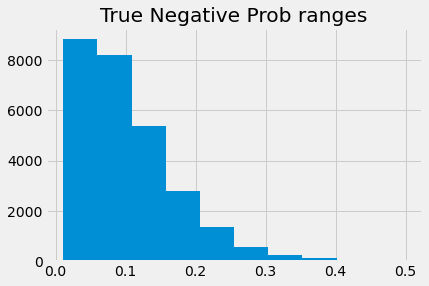

In [14]:
fig, ax = plt.subplots()
plt.hist(true_pos)
ax.set_title('True Positive Prob ranges')
fig, ax = plt.subplots()
plt.hist(true_neg)
ax.set_title('True Negative Prob ranges')

Text(0.5, 1.0, 'False Prob ranges')

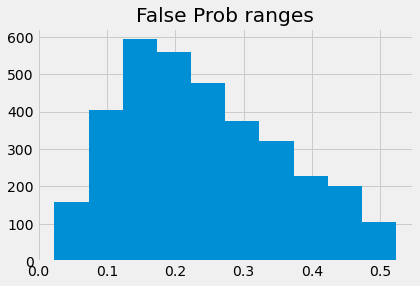

In [15]:
fig, ax = plt.subplots()
plt.hist(err)
ax.set_title('False Prob ranges')

In [16]:
# cutoffs = [.1, .15, .2, .25, .3, .35, .4, .5]
# for cut in cutoffs:
#     y_hat = out['prob'] >= cut
#     cm = confusion_matrix(out['y'], y_hat)
#     ras = roc_auc_score(y, y_hat)
#     print(f'For {cut} threshold:')
#     print('confusion matrix:')
#     print(cm)
#     print('roc auc score:')
#     print(ras)



<AxesSubplot:title={'center':'Random Forest Classifier: Top 10 Feature Importance by Fraction of Samples Affected'}, ylabel='Feature'>

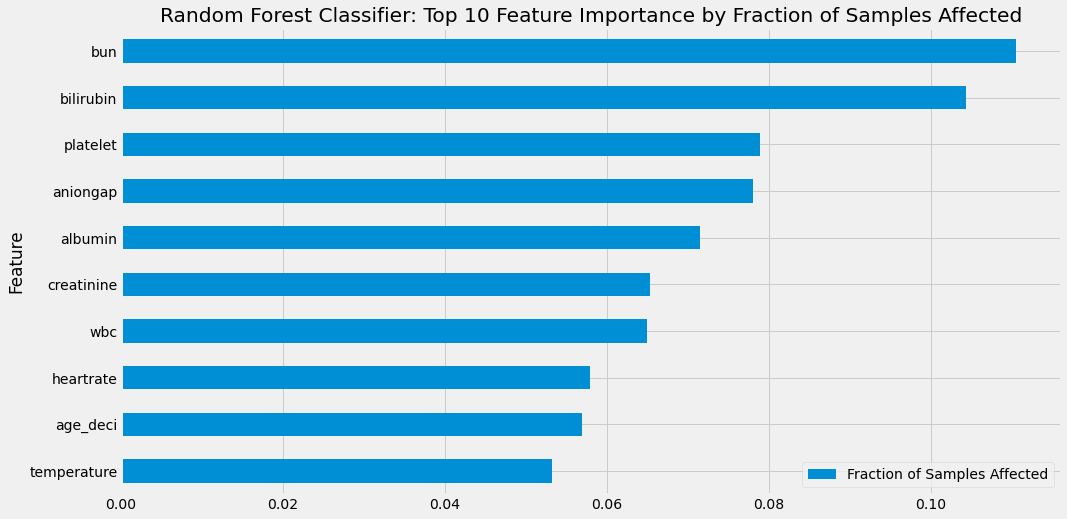

In [17]:
ft_scores = pd.DataFrame({'Fraction of Samples Affected' : cm_rf.feature_importances_},
                           index=X.columns)
ft_scores=ft_scores.sort_values(by='Fraction of Samples Affected').iloc[-10:,:]
ft_scores.plot(kind='barh', figsize=(15,8), title = 'Random Forest Classifier: Top 10 Feature Importance by Fraction of Samples Affected', xlabel='Feature', ylabel='Fraction of Samples Affected')

Content below is model training activities and evaluations.  Above line is edited and consumable summary of final project along with results.